In [1]:
# pip install xesmf
# !pip install climate_indices


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# pip install xclim 

In [4]:
import xclim 
import xarray as xr
from pathlib import Path
# import dask 
import os 

In [5]:
from Barcelona import indicators_Barcelona as iB 

In [6]:
import numpy as np 
import xarray as xr

# import geopandas as gpd


# import rioxarray
# import xarray
# from shapely.geometry import mapping


In [7]:
path_data = Path('/mnt/stg/climate/CHELSA/CHELSA_EUR11/obs/daily/pr/')
outpath = '/mnt/stg/climate/CHELSA/CHELSA_EUR11/indicators/cdd/'

# Catalonia
lat_min, lat_max = 40.3, 42.6
lon_min, lon_max = -1.3, 3.4

# nc_files = list(path_data.glob("*_V1.1.nc") )
# nc_files


In [9]:
# tmp = xr.open_dataset('/mnt/stg/climate/EMO_1/pr/mon/nc/high-resolution/EMO-1arcmin-pr_1990.nc')
# chelsa =  xr.open_dataset("/mnt/stg/climate/CHELSA/CHELSA_EUR11/obs/mon/pr/CHELSA_EUR11_pr_day_1990_V1.1.nc")
# tmp_regrid =  tmp.interp(lat=chelsa.lat, lon=chelsa.lon)
# mask = tmp_regrid.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)).isel(time=1)

In [8]:
tmp = xr.open_dataset('/mnt/stg/climate/CHELSA/CHELSA_EUR11/obs/daily/tasmax/mask.nc')
mask = tmp['tasmax'].sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)).isel(time=0)

In [12]:
mask

<xarray.DataArray 'tasmax' (lat: 276, lon: 564)> Size: 623kB
[155664 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 2002-01-01T12:00:00
  * lon      (lon) float64 5kB -1.296 -1.288 -1.279 -1.271 ... 3.379 3.387 3.396
  * lat      (lat) float64 2kB 40.3 40.31 40.32 40.33 ... 42.57 42.58 42.59 42.6
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    units:          Celsius
    grid_mapping:   crs

In [9]:
years = range(1990, 2006)

data_dir = '/mnt/stg/climate/CHELSA/CHELSA_EUR11/obs/daily/pr/' 
datasets = []

for year in years:
    file_path = os.path.join(data_dir, f"CHELSA_EUR11_pr_day_{year}_V1.1.nc")
    try:
        # with xr.open_dataset(file_path,chunks={'lat':100, 'lon':100, 'time':100},engine="netcdf4") as ds:
        with xr.open_dataset(file_path,engine="netcdf4") as ds:
            # Subset before loading into memory
            ds_subset = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
            # correct the values 
            # ds_subset = ds_subset.where(ds_subset <= 200000) 
            # scale 
            ds_subset = ds_subset*0.01             
            # rename 
            ds_subset = ds_subset.rename({'Band1':'pr'})
            # mask
            ds_subset_masked = ds_subset.where(mask.notnull())
            # Actually load data into memory now
            datasets.append(ds_subset_masked.load())
            print(f"Year {year}: loaded")
    except Exception as e:
        print(f"Skipping year {year}: {e}")

# Concatenate all loaded subsets along the time dimension
combined = xr.concat(datasets, dim="time")


Year 1990: loaded
Year 1991: loaded
Year 1992: loaded
Year 1993: loaded
Year 1994: loaded
Year 1995: loaded
Year 1996: loaded
Year 1997: loaded
Year 1998: loaded
Year 1999: loaded
Year 2000: loaded
Year 2001: loaded
Year 2002: loaded
Year 2003: loaded
Year 2004: loaded
Year 2005: loaded


In [11]:
combined

<xarray.Dataset> Size: 11GB
Dimensions:  (time: 5844, lat: 276, lon: 564)
Coordinates:
  * time     (time) float64 47kB 1.99e+07 1.99e+07 ... 2.005e+07 2.005e+07
  * lon      (lon) float64 5kB -1.296 -1.288 -1.279 -1.271 ... 3.379 3.387 3.396
  * lat      (lat) float64 2kB 40.3 40.31 40.32 40.33 ... 42.57 42.58 42.59 42.6
Data variables:
    crs      (time, lat, lon) float64 7GB 0.01 0.01 0.01 0.01 ... nan nan nan
    pr       (time, lat, lon) float32 4GB 1.09 1.05 1.02 0.99 ... nan nan nan
Attributes:
    CDI:                       Climate Data Interface version ?? (http://mpim...
    history:                   Thu Aug 13 10:21:41 2020: cdo mergetime /stora...
    Conventions:               CF-1.5
    GDAL_AREA_OR_POINT:        Area
    GDAL:                      GDAL 2.2.3, released 2017/11/20
    cdo_openmp_thread_number:  20
    CDO:                       Climate Data Operators version 1.9.3 (http://m...

In [ ]:
combined['pr'].isel(time=1).plot()

In [ ]:
combined2 = combined.copy(deep=True)

In [12]:
import pandas as pd

# Create monthly date range from 1990-01-01 to 2005-12-01 (start of each month)
time_index = pd.date_range(start='1990-01-01', end='2005-12-31', freq='D')  # MS = month start

# Assign to your dataset (assuming 'time' is the time dimension)
combined = combined.assign_coords(time=time_index)

print(combined.time.values)


['1990-01-01T00:00:00.000000000' '1990-01-02T00:00:00.000000000'
 '1990-01-03T00:00:00.000000000' ... '2005-12-29T00:00:00.000000000'
 '2005-12-30T00:00:00.000000000' '2005-12-31T00:00:00.000000000']


combined 

In [15]:
combined 

<xarray.Dataset> Size: 11GB
Dimensions:  (time: 5844, lat: 276, lon: 564)
Coordinates:
  * lon      (lon) float64 5kB -1.296 -1.288 -1.279 -1.271 ... 3.379 3.387 3.396
  * lat      (lat) float64 2kB 40.3 40.31 40.32 40.33 ... 42.57 42.58 42.59 42.6
  * time     (time) datetime64[ns] 47kB 1990-01-01 1990-01-02 ... 2005-12-31
Data variables:
    crs      (time, lat, lon) float64 7GB 0.01 0.01 0.01 0.01 ... nan nan nan
    pr       (time, lat, lon) float32 4GB 1.09 1.05 1.02 0.99 ... nan nan nan
Attributes:
    CDI:                       Climate Data Interface version ?? (http://mpim...
    history:                   Thu Aug 13 10:21:41 2020: cdo mergetime /stora...
    Conventions:               CF-1.5
    GDAL_AREA_OR_POINT:        Area
    GDAL:                      GDAL 2.2.3, released 2017/11/20
    cdo_openmp_thread_number:  20
    CDO:                       Climate Data Operators version 1.9.3 (http://m...

In [17]:
print(combined.time.values)


['1990-01-01T00:00:00.000000000' '1990-01-02T00:00:00.000000000'
 '1990-01-03T00:00:00.000000000' ... '2005-12-29T00:00:00.000000000'
 '2005-12-30T00:00:00.000000000' '2005-12-31T00:00:00.000000000']


In [18]:
# txx = iB.txx(combined['tasmax'])
cdd = iB.cdd(combined['pr'])


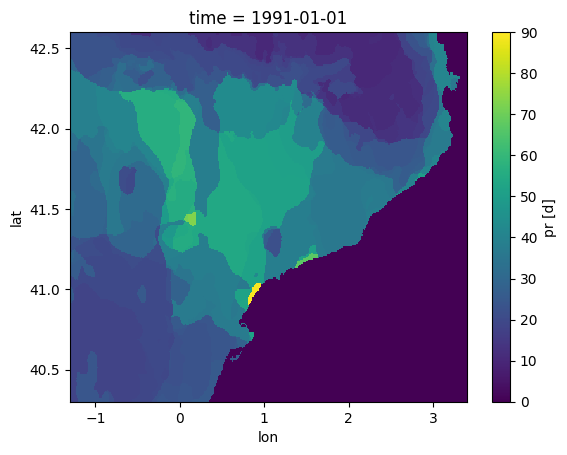

In [24]:
cdd.isel(time=1).plot(vmax=90)  

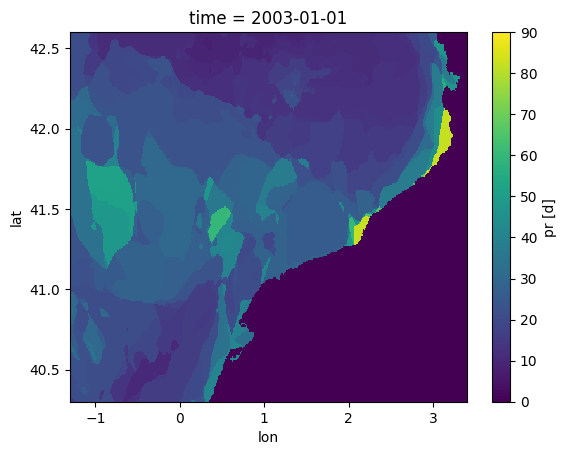

In [27]:
cdd.isel(time=13).plot(vmax=90)  

In [28]:
cdd.to_netcdf(f"{outpath}Cdd_Catalonia_1990_2005.nc")

In [29]:
cdd.mean(dim='time').to_netcdf(f"{outpath}Cdd_Catalonia_1990_2005_mean.nc")